In [12]:
# importing required library to perform feature selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# importing the dataset
input_file = "chowdary.csv"
df = pd.read_csv(input_file)

# seperating the independent and dependent variables
X = df.iloc[:, 3:]
Y = df.iloc[:, 1]

# splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# summarizing the dataset
# number of 'B' and 'C' in training and testing set
print("The number of 'B' and 'C' in training set: ", Y_train.value_counts())
print("The number of 'B' and 'C' in testing set: ", Y_test.value_counts())
print("The shape of the training set is: ", X_train_normalized_df.shape)
print("The shape of the testing set is: ", X_test_normalized_df.shape)

The number of 'B' and 'C' in training set:  tumour
B    52
C    31
Name: count, dtype: int64
The number of 'B' and 'C' in testing set:  tumour
C    11
B    10
Name: count, dtype: int64
The shape of the training set is:  (83, 181)
The shape of the testing set is:  (21, 181)


In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the Support Vector Machine classifier
svc = SVC()

# Define the hyperparameters grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
}

# Create the GridSearchCV object
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_svc.fit(X_train_normalized_df, Y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search_svc.best_params_)

Best parameters:  {'C': 1, 'degree': 2, 'kernel': 'rbf'}


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import StratifiedKFold

# Range of k values to test
k_values = list(range(1, X_train_normalized_df.shape[1] + 1))

# Initialize the best k value and its corresponding score
best_k = None
best_score = -1

# Initialize the cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Loop through all k values
for k in k_values:
    # Select the k best features
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_normalized_df, Y_train)
    X_train_selected = selector.transform(X_train_normalized_df)

    # Train and evaluate the SVC model with the selected features
    estimator = SVC(C=1, degree=2, kernel='rbf')
    cv_scores = cross_val_score(estimator, X_train_selected, Y_train, cv=cv, scoring='accuracy')
    mean_cv_score = cv_scores.mean()

    # Update the best k and best score if the current score is better
    if mean_cv_score > best_score:
        best_k = k
        best_score = mean_cv_score

# Print the best k value and its corresponding score
print("Optimal number of features: ", best_k)
print("Best cross-validation score: ", best_score)

# Get the final selected features
selector = SelectKBest(mutual_info_classif, k=best_k)
selector.fit(X_train_normalized_df, Y_train)
selected_indices = selector.get_support(indices=True)
selected_features = X_train_normalized_df.columns[selected_indices]
print("Selected features: ", selected_features)

# Transform the datasets using the selected features
X_train_selected = selector.transform(X_train_normalized_df)
X_test_selected = selector.transform(X_test_normalized_df)

Optimal number of features:  4
Best cross-validation score:  0.975
Selected features:  Index(['X202831_at', 'X204272_at', 'X204653_at', 'X205137_x_at'], dtype='object')


              precision    recall  f1-score   support

           B       0.77      1.00      0.87        10
           C       1.00      0.73      0.84        11

    accuracy                           0.86        21
   macro avg       0.88      0.86      0.86        21
weighted avg       0.89      0.86      0.86        21



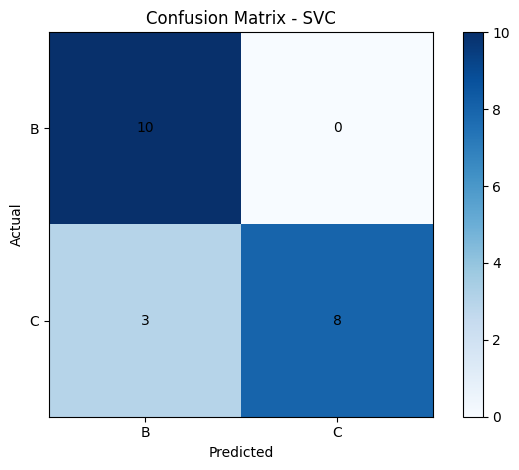

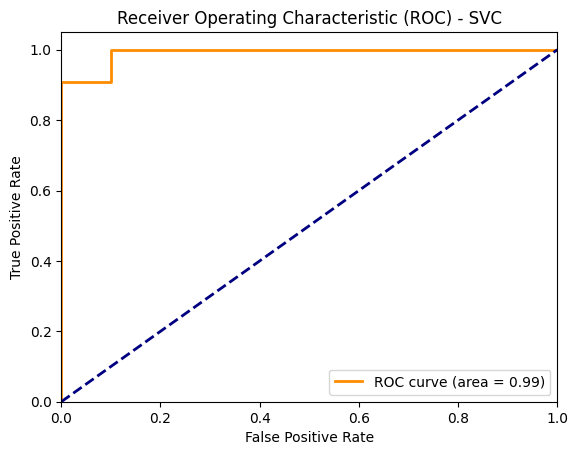

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

X_train_rf = X_train[selected_features]
X_test_rf = X_test[selected_features]

# Fit the SVC model
svc = SVC(C=1, degree=2, kernel='rbf', probability=True)
svc.fit(X_train_rf, Y_train)

# Make predictions
Y_pred_svc = svc.predict(X_test_rf)
Y_pred_proba_svc = svc.predict_proba(X_test_rf)[:, 1]

# Print classification report
print(classification_report(Y_test, Y_pred_svc))

# Confusion matrix
conf_mat_svc = confusion_matrix(Y_test, Y_pred_svc)
plt.imshow(conf_mat_svc, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(len(conf_mat_svc)):
    for j in range(len(conf_mat_svc[0])):
        plt.text(j, i, str(conf_mat_svc[i][j]), horizontalalignment='center', verticalalignment='center')
tick_marks = np.arange(len(np.unique(df['tumour'])))
plt.xticks(tick_marks, np.unique(df['tumour']))
plt.yticks(tick_marks, np.unique(df['tumour']))
plt.tight_layout()
plt.show()

# ROC curve for SVC
fpr_svc, tpr_svc, _ = roc_curve(Y_test, Y_pred_proba_svc, pos_label=df['tumour'].unique()[1])
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.figure()
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVC')
plt.legend(loc="lower right")
plt.show()